In [1]:
from scipy.sparse import csr_matrix
from math import ceil, floor

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import scipy.sparse as sp
import pandas as pd
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset

In [ ]:
!wget -c "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv"
!wget -c "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-02.csv"

In [3]:
data_jan = pd.read_csv("yellow_tripdata_2016-01.csv")
data_feb = pd.read_csv("yellow_tripdata_2016-02.csv")
data = pd.concat([data_jan, data_feb])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22288907 entries, 0 to 11382048
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        int64  
 4   trip_distance          float64
 5   pickup_longitude       float64
 6   pickup_latitude        float64
 7   RatecodeID             int64  
 8   store_and_fwd_flag     object 
 9   dropoff_longitude      float64
 10  dropoff_latitude       float64
 11  payment_type           int64  
 12  fare_amount            float64
 13  extra                  float64
 14  mta_tax                float64
 15  tip_amount             float64
 16  tolls_amount           float64
 17  improvement_surcharge  float64
 18  total_amount           float64
dtypes: float64(12), int64(4), object(3)
memory usage: 3.3+ GB


In [4]:
data.drop([
    'VendorID', 'passenger_count', 'RatecodeID', 'store_and_fwd_flag', 
    'payment_type', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
    'improvement_surcharge', 'total_amount'], 
    axis=1,
    inplace = True
)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22288907 entries, 0 to 11382048
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   tpep_pickup_datetime   object 
 1   tpep_dropoff_datetime  object 
 2   trip_distance          float64
 3   pickup_longitude       float64
 4   pickup_latitude        float64
 5   dropoff_longitude      float64
 6   dropoff_latitude       float64
 7   fare_amount            float64
dtypes: float64(6), object(2)
memory usage: 1.5+ GB


In [5]:
# filter the data by latitude, longitude
import json
manhattan_boundary = json.load(open('manhattan.geojson', 'r'))
coords = manhattan_boundary['features'][0]['geometry']['coordinates'][0]

min_lon = min([lon for lon, _ in coords])
max_lon = max([lon for lon, _ in coords])
min_lat = min([lat for _, lat in coords])
max_lat = max([lat for _, lat in coords])

data = data[(data["pickup_latitude"] >= min_lat) & (data["pickup_latitude"] <= max_lat) &
                (data["pickup_longitude"] >= min_lon) & (data["pickup_longitude"] <= max_lon) &
                (data["dropoff_latitude"] >= min_lat) & (data["dropoff_latitude"] <= max_lat) &
                (data["dropoff_longitude"] >= min_lon) & (data["dropoff_longitude"] <= max_lon)]

In [6]:
# filter data by fare_amount
print("99.9% of the fare amounts are less than: ", data["fare_amount"].quantile(q=0.999), "dollars")
data = data[(data["fare_amount"] > 0) & (data["fare_amount"] < 53)]

99.9% of the fare amounts are less than:  52.0 dollars


In [7]:
# filter data by trip_distance
print("99.9% of the rip distances are less than: ", data["trip_distance"].quantile(q=0.999), "miles")
data = data[(data["trip_distance"] > 0) & (data["trip_distance"] < 12)]

99.9% of the rip distances are less than:  11.1 miles


In [8]:
data['tpep_pickup_datetime']= pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime']= pd.to_datetime(data['tpep_dropoff_datetime']) 

data["trip_duration"] = (data["tpep_dropoff_datetime"] - data["tpep_pickup_datetime"]).dt.total_seconds()
print("99.9% of the trip duratins are less than: ", data["trip_duration"].quantile(q=0.999), "seconds")
data = data[(data["trip_duration"] > 0) & (data["trip_duration"] < 24*3600) ]

99.9% of the trip duratins are less than:  85476.0 seconds


In [9]:
data["speed"] = data["trip_distance"] / (data["trip_duration"] / 3600)
print("99.9% of the trip speeds are less than: ", data["speed"].quantile(q=0.999), "mph")
data = data[(data["speed"] > 0) & (data["speed"] < 60)]

99.9% of the trip speeds are less than:  36.891982901268996 mph


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19343809 entries, 5 to 11382039
Data columns (total 10 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   trip_distance          float64       
 3   pickup_longitude       float64       
 4   pickup_latitude        float64       
 5   dropoff_longitude      float64       
 6   dropoff_latitude       float64       
 7   fare_amount            float64       
 8   trip_duration          float64       
 9   speed                  float64       
dtypes: datetime64[ns](2), float64(8)
memory usage: 1.6 GB


In [11]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = R = 6371.0 * c # 6371 radius of the earth in km
    return km * 1000


In [12]:
grid_side_length = 350  # 350m
time_interval_length = 20  # 20 min

width = haversine_np(min_lon, min_lat, max_lon, min_lat)
height = haversine_np(min_lon, min_lat, min_lon, max_lat)

print(width, height)

H = ceil(height / grid_side_length)
W = ceil(width / grid_side_length)

print(H, W, H*W)

bottom_left_lon = np.array([min_lon] * data.shape[0])
bottom_left_lat = np.array([min_lat] * data.shape[0])
min_timestamp = pd.Timestamp('2016-01-01 00:00:00')


def set_grid_index(data):
  src_x = haversine_np(bottom_left_lon, bottom_left_lat, data["pickup_longitude"], bottom_left_lat)
  src_y = haversine_np(bottom_left_lon, bottom_left_lat, bottom_left_lon, data["pickup_latitude"])

  src_x = np.floor(src_x / grid_side_length)
  src_y = np.floor(src_y / grid_side_length)
  data["pickup_grid"] = src_y * W + src_x

  dest_x = haversine_np(bottom_left_lon, bottom_left_lat, data["dropoff_longitude"], bottom_left_lat)
  dest_y = haversine_np(bottom_left_lon, bottom_left_lat, bottom_left_lon, data["dropoff_latitude"])
  dest_x = np.floor(dest_x / grid_side_length)
  dest_y = np.floor(dest_y / grid_side_length)
  data["dropoff_grid"] = dest_y * W + dest_x


def set_timeinterval_index(data):
  time_delta_minutes = (data["tpep_pickup_datetime"] - min_timestamp).dt.total_seconds() / 60
  data["pickup_timeinterval_index"] = np.floor(time_delta_minutes / time_interval_length)

10303.529670673082 19914.53188192843
57 30 1710


In [13]:
set_grid_index(data)
set_timeinterval_index(data)
data = data.astype({'pickup_grid': 'int32', 'dropoff_grid': 'int32', 'pickup_timeinterval_index': 'int32'})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19343809 entries, 5 to 11382039
Data columns (total 13 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   tpep_pickup_datetime       datetime64[ns]
 1   tpep_dropoff_datetime      datetime64[ns]
 2   trip_distance              float64       
 3   pickup_longitude           float64       
 4   pickup_latitude            float64       
 5   dropoff_longitude          float64       
 6   dropoff_latitude           float64       
 7   fare_amount                float64       
 8   trip_duration              float64       
 9   speed                      float64       
 10  pickup_grid                int32         
 11  dropoff_grid               int32         
 12  pickup_timeinterval_index  int32         
dtypes: datetime64[ns](2), float64(8), int32(3)
memory usage: 1.8 GB


In [14]:
data

,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,trip_duration,speed,pickup_grid,dropoff_grid,pickup_timeinterval_index
5,2016-01-01 00:00:00,2016-01-01 00:18:30,5.52,-73.980118,40.743050,-73.913490,40.763142,19.0,1110.0,17.902703,401,627,0
6,2016-01-01 00:00:00,2016-01-01 00:26:45,7.45,-73.994057,40.719990,-73.966362,40.789871,26.0,1605.0,16.710280,187,854,0
7,2016-01-01 00:00:01,2016-01-01 00:11:55,1.20,-73.979424,40.744614,-73.992035,40.753944,9.0,714.0,6.050420,431,518,0
8,2016-01-01 00:00:02,2016-01-01 00:11:14,6.00,-73.947151,40.791046,-73.920769,40.865578,18.0,672.0,32.142857,889,1585,0
10,2016-01-01 00:00:03,2016-01-01 00:06:19,0.79,-74.006149,40.744919,-73.993797,40.741440,6.0,376.0,7.563830,425,398,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11381951,2016-02-29 00:27:03,2016-02-29 00:40:38,3.67,-73.986336,40.762405,-73.940002,40.747936,13.5,815.0,16.211043,579,471,4249
11381991,2016-02-25 21:06:04,2016-02-26 14:45:08,1.81,-73.986519,40.760239,-74.004860,40.741810,10.0,63544.0,0.102543,579,395,4023
11382036,2016-02-13 22:40:05,2016-02-13 22:49:30,0.60,-73.983788,40.744068,-73.991463,40.749416,7.0,565.0,3.823009,430,458,3164
11382037,2016-02-13 22:43:23,2016-02-13 23:12:01,1.50,-73.987480,40.768906,-73.966599,40.764339,17.0,1718.0,3.143190,669,614,3164


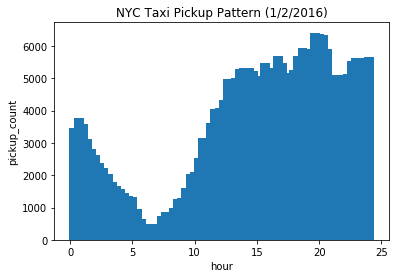

In [15]:
pickup_data = data.groupby('pickup_timeinterval_index').size().reset_index(name='pickup_count')
pickup_data['hour'] = pickup_data['pickup_timeinterval_index'] / 3

f = plt.figure()
plt.bar(
    pickup_data[(pickup_data['hour'] > 23) & (pickup_data['hour'] <= 47)]['hour'] - 23,
    pickup_data[(pickup_data['hour'] > 23) & (pickup_data['hour'] <= 47)]['pickup_count']
)
plt.xlabel('hour')
plt.ylabel('pickup_count')
plt.title('NYC Taxi Pickup Pattern (1/2/2016)')
f.savefig("pickups_by_hour.png", bbox_inches='tight', dpi=600)

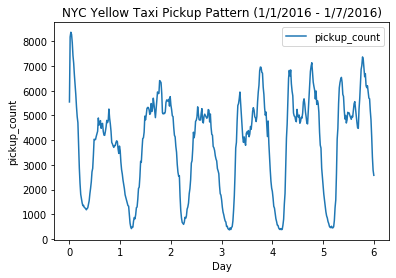

In [16]:
pickup_data['day'] = pickup_data['pickup_timeinterval_index'] / (3*24)
pl = pickup_data[pickup_data["day"] <= 6].plot(x='day', y='pickup_count')

plt.title("NYC Yellow Taxi Pickup Pattern (1/1/2016 - 1/7/2016)")
plt.ylabel('pickup_count')
plt.xlabel('Day')
# f.savefig("pickups_by_day.png", bbox_inches='tight', dpi=600)

fig = pl.get_figure()
fig.savefig('pickups_by_day.png')

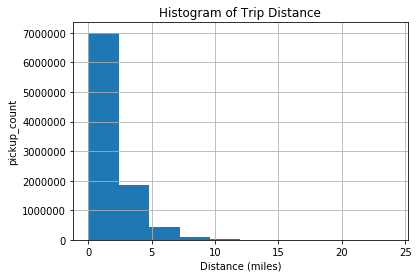

In [17]:
f = plt.figure()
distance_data = data['trip_distance'].hist()
plt.ylabel('pickup_count')
plt.xlabel('Distance (miles)')
plt.title('Histogram of Trip Distance')
f.savefig("trip_distance_histogram.png", bbox_inches='tight', dpi=600)

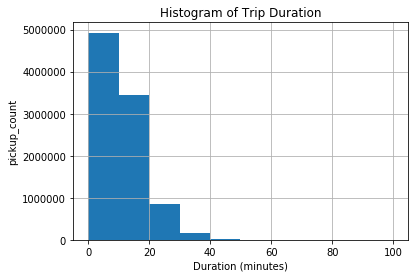

In [18]:
f = plt.figure()
duration_data = (data[data['trip_duration'] < 100*60]['trip_duration'] / 60).hist()
plt.ylabel('pickup_count')
plt.xlabel('Duration (minutes)')
plt.title('Histogram of Trip Duration')
f.savefig("trip_duration_histogram.png", bbox_inches='tight', dpi=600)

In [15]:
from utils import normalize_adj

graph_data = data[["pickup_grid", "dropoff_grid", "pickup_timeinterval_index"]]
max_timeinterval_index = max(graph_data["pickup_timeinterval_index"])+1
number_of_nodes = H*W

nets = torch.zeros((max_timeinterval_index, number_of_nodes, number_of_nodes))
print('Initialized')

pickup_counts = np.zeros((number_of_nodes, max_timeinterval_index))
dropoff_counts = np.zeros_like(pickup_counts)

for t in range(max_timeinterval_index):
    t_graph_data = graph_data[graph_data["pickup_timeinterval_index"] == t]
    src, dest = t_graph_data['pickup_grid'], t_graph_data['dropoff_grid']
    pickups = t_graph_data.groupby('pickup_grid').size().to_dict()
    dropoffs = t_graph_data.groupby('dropoff_grid').size().to_dict()
    
    pickup_counts[list(pickups.keys()), t] = list(pickups.values())
    dropoff_counts[list(dropoffs.keys()), t] = list(dropoffs.values())
    
    adj = csr_matrix((np.ones(len(src)), (src, dest)), shape=(H*W, H*W))
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)  # make adj symmetric, for application of GAT
    adj = normalize_adj(adj + sp.eye(adj.shape[0]))  # add self edges and normalize
    
    nets[t] = torch.Tensor(adj.todense())


nets.shape

Initialized


torch.Size([4320, 1710, 1710])

In [16]:
from scipy import fftpack
sig_fft = fftpack.fft(pickup_counts)
sig_fft_real = 2 * np.abs(sig_fft / pickup_counts.shape[1])
sig_freqs = fftpack.fftfreq(pickup_counts.shape[1], 1 / (24 * 3))

sig_fft_real.shape, sig_freqs.shape

((1710, 4320), (4320,))

In [17]:
freq_mask = (sig_freqs > 0) & (sig_freqs < 3.1)  # Taking only positive frequencies, and time_period < 3 days
sig_freqs_masked = sig_freqs[freq_mask]

freq_mask = np.tile(freq_mask, (number_of_nodes, 1))
sig_fft_real_masked = sig_fft_real[freq_mask].reshape(number_of_nodes, -1)

sig_freqs_masked.shape, sig_fft_real_masked.shape

((185,), (1710, 185))

In [18]:
fourier_features = np.hstack((
    np.tile(sig_freqs_masked, (number_of_nodes, 1)),
    sig_fft_real_masked
))

fourier_features.shape
# fourier_frequencies = sig_freqs_masked  # same for all nodes
# fourier_amplitudes  = sig_fft_real_masked

(1710, 370)

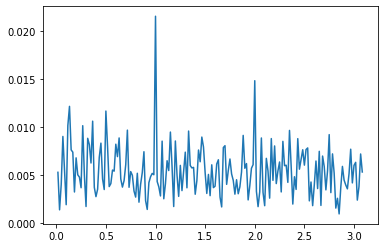

In [19]:
grid_index = 50
plt.plot(sig_freqs_masked, sig_fft_real_masked[grid_index])

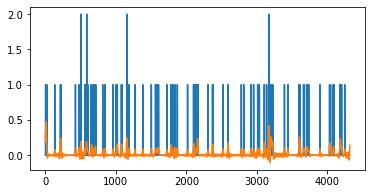

In [23]:
# visualize reconstruction quality from frequency domain
signal = pickup_counts[grid_index]

sig_fft_reg = sig_fft[grid_index].copy()
sig_fft_reg[np.abs(sig_freqs) > 3.1] = 0

sig_reg = np.real(fftpack.ifft(sig_fft_reg))
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(signal)
ax.plot(sig_reg, '-')
# print(min(sig_reg))

In [24]:
def get_time_features(timeIntervalIndex, number_of_nodes):
    # hour of day, day of week: will be same for all nodes in the particular time interval
    time_interval_starting_timestamp = min_timestamp + timeIntervalIndex * pd.Timedelta('%s minutes' % time_interval_length)
    hour_of_day = time_interval_starting_timestamp.hour
    day_of_week = time_interval_starting_timestamp.dayofweek
    month_of_year = time_interval_starting_timestamp.month - 1
    
    # print(hour_of_day, day_of_week, month_of_year)
    
    hour = np.zeros((number_of_nodes, 24))
    hour[:, hour_of_day] = 1
    
    day = np.zeros((number_of_nodes, 7))
    day[:, day_of_week] = 1
    
    month = np.zeros((number_of_nodes, 12))
    month[:, month_of_year] = 1
    
    return np.hstack((hour, day, month))

In [24]:
%reset Out

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Flushing output cache (6 entries)


In [25]:
'''
feature dimensions:
hour_of_day: possible values are 0-23, Dimension in one hot encoding = 24
day of week: possible values: 0-6, Dimension in one hot encoding = 7
month of year: possible values: 0-11, Dimension in one hot encoding = 12
pickup count history: Dimension 's'
weighted moving avergae of pickup count: Dimension 1
dropoff count history: 2 hours data, 2*3 = 6 timeinterval data, Dimesion 6
fourier frequencies: Dimension 96
fourier amplitudes: Dimension 96
Total Dimension: (24 + 7 + 12 + s + 1 + 6 + 96 * 2)
'''

s = 4
feature_dimension = 24 + 7 + 12 + s + 1 + 6 + fourier_features.shape[1]

calculated_features = torch.zeros((max_timeinterval_index, number_of_nodes, feature_dimension))

for t in range(max_timeinterval_index):
    # print('time interval index: %s/%s' % (t, max_timeinterval_index))
    X_time_features = get_time_features(t, number_of_nodes)
    # print(X_time_features.shape)
    
    # gather pickup historical values
    # handle previous timeinterval data not available case here
    # currently python is doing negative indexing
    historical_pickup_timeIntervalIndices = list(range(t - s * 7 * 24 * 3, t, 7 * 24 * 3))
    pickup_count_history = pickup_counts[:, historical_pickup_timeIntervalIndices]    
    # print(pickup_count_history.shape)
    
    # calculate weighted moving average of pickups
    weights = np.arange(1, s+1)
    weighted_moving_avg_pickup = np.dot(pickup_count_history, weights).reshape(-1, 1) / (s*(s+1)/2)
    # print(weighted_moving_avg_pickup.shape)
    
    # gather dropoff numbers in the previous day: 
    # go back one day, use sum of dropoff numbers starting at that time and or next 2 hours, i.e 2*3 = 6 time intervals
    historical_dropoff_timeIntervalIndices = list(range(t - 24 * 3, t - 24 * 3 + 6))
    dropoff_count_history = dropoff_counts[:, historical_dropoff_timeIntervalIndices]
    # print(dropoff_count_history.shape)
    
    # fourier frequencies
    # fourier_freqs = np.tile(fourier_frequencies, (number_of_nodes, 1))
    # print(fourier_freqs.shape)
    
    # fourier amplitudes
    # print(fourier_amplitudes.shape)
    
    calculated_features[t] = torch.Tensor(np.hstack((
        X_time_features, pickup_count_history, weighted_moving_avg_pickup, dropoff_count_history, fourier_features
    )))
    

calculated_features.shape

torch.Size([4320, 1710, 424])

In [26]:
# normalize the features
train_start_index = s * 7 * 24 * 3
dataset_size = len(range(train_start_index, max_timeinterval_index))
train_size = int(dataset_size * 0.8)

scaler = StandardScaler()

# scale data using only the training data
for t in range(train_start_index, train_start_index + train_size):
    scaler.partial_fit(calculated_features[t])
    
for t in range(train_start_index, max_timeinterval_index):
    calculated_features[t] = torch.Tensor(scaler.transform(calculated_features[t]))

In [27]:
target_values = torch.Tensor(pickup_counts.T)

adj_indices = torch.zeros((max_timeinterval_index, s), dtype=torch.long)
for t in range(train_start_index, max_timeinterval_index):
    adj_indices[t] = torch.arange(t - s * 7 * 24 * 3, t, 7 * 24 * 3, dtype=torch.long)

In [28]:
# Design a dataloader
dataset = TensorDataset(
    calculated_features[train_start_index:, ], 
    adj_indices[train_start_index:, ], 
    target_values[train_start_index:, ]
)

train_dataset, val_dataset = Subset(dataset, range(train_size)), Subset(dataset, range(train_size, len(dataset)))

train_dataloader = DataLoader(train_dataset, batch_size=None, shuffle=False, pin_memory=False)
val_dataloader = DataLoader(val_dataset, batch_size=None, shuffle=False, pin_memory=False)

print(len(train_dataloader), len(val_dataloader))

1843 461


In [29]:
from gat_layers import GraphAttentionLayer

class GAT(nn.Module):
    def __init__(self, nfeat, nhid, dropout, alpha, nheads):
        """Dense version of GAT."""
        super(GAT, self).__init__()
        self.dropout = dropout

        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

    def forward(self, x, adj):
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        # print(x.shape)
        return x

In [30]:
class Model(nn.Module):
    def __init__(self, seq_length, feature_length, hidden_length, dropout, alpha, nheads):
        super(Model, self).__init__()
        
        self.gats = [GAT(feature_length, hidden_length, dropout, alpha, nheads) for _ in range(seq_length)]
        for i, gat in enumerate(self.gats):
            self.add_module('gat_{}'.format(i), gat)
            
        self.gru = nn.GRU(hidden_length*nheads, hidden_length)
        self.add_module('gru', self.gru)
        
        self.fc = nn.Linear(hidden_length*seq_length, 1)
        self.add_module('fc', self.fc)
        
        self.relu = nn.ReLU()
        self.add_module('relu', self.relu)
            
    def forward(self, x, adjs):
        # assert(len(adjs) == len(self.gats))
        # adjs = nets[adj_indices]
        seq_x = [gat(x, adj) for gat, adj in zip(self.gats, adjs)]
        x = torch.stack(seq_x)
        x, h = self.gru(x)
        x = x.permute(1, 0, 2).contiguous().view(number_of_nodes, -1)
        x = self.relu(self.fc(x))
        # print(x.shape)
        return x

In [32]:
import torch.optim as optim

model = Model(
    seq_length= s,
    feature_length = feature_dimension,
    hidden_length = 8,
    dropout = 0.5,
    alpha = 0.2,
    nheads = 8
)

optimizer = optim.Adam(
    model.parameters(), 
    lr=0.005, 
    weight_decay=5e-4
)

model.cuda()

Model(
  (gat_0): GAT(
    (attention_0): GraphAttentionLayer (424 -> 8)
    (attention_1): GraphAttentionLayer (424 -> 8)
    (attention_2): GraphAttentionLayer (424 -> 8)
    (attention_3): GraphAttentionLayer (424 -> 8)
    (attention_4): GraphAttentionLayer (424 -> 8)
    (attention_5): GraphAttentionLayer (424 -> 8)
    (attention_6): GraphAttentionLayer (424 -> 8)
    (attention_7): GraphAttentionLayer (424 -> 8)
  )
  (gat_1): GAT(
    (attention_0): GraphAttentionLayer (424 -> 8)
    (attention_1): GraphAttentionLayer (424 -> 8)
    (attention_2): GraphAttentionLayer (424 -> 8)
    (attention_3): GraphAttentionLayer (424 -> 8)
    (attention_4): GraphAttentionLayer (424 -> 8)
    (attention_5): GraphAttentionLayer (424 -> 8)
    (attention_6): GraphAttentionLayer (424 -> 8)
    (attention_7): GraphAttentionLayer (424 -> 8)
  )
  (gat_2): GAT(
    (attention_0): GraphAttentionLayer (424 -> 8)
    (attention_1): GraphAttentionLayer (424 -> 8)
    (attention_2): GraphAttentionLaye

In [33]:
def train(feature, adjs, target_value):
    model.train()
    optimizer.zero_grad()
    output = model(feature, adjs)
    loss_train = F.mse_loss(output, target_value)
    loss_train.backward()
    optimizer.step()
    return loss_train.item()

In [34]:
# Train model
def train_model(number_of_epochs):
    train_losses_by_epoch = []
    val_losses_by_epoch = []
    for epoch in range(number_of_epochs):
        train_losses = []
        for i, (feature, adj_ind, target_value) in enumerate(train_dataloader):
            adjs = nets[adj_ind]
            loss = train(feature.cuda(), adjs.cuda(), target_value.reshape(number_of_nodes, -1).cuda())
            train_losses.append(loss)
            if (i % 100 == 0): print('i=',i,'train rmse loss', np.mean(np.sqrt(train_losses)))
            
        mean_train_loss = np.mean(np.sqrt(train_losses))
        mean_val_loss = get_validation_loss()
        
        train_losses_by_epoch.append(mean_train_loss)
        val_losses_by_epoch.append(mean_val_loss)
        
        print(
            'Epoch: {:04d}'.format(epoch+1),
            'train rmse loss: {:.4f}'.format(mean_train_loss),
            'val rmse loss: {:.4f}'.format(mean_val_loss)
        )
    return train_losses_by_epoch, val_losses_by_epoch


def get_validation_loss():
    val_losses = []
    for i, (feature, adj_ind, target_value) in enumerate(val_dataloader):
        model.eval()
        adjs = nets[adj_ind]
        output = model(feature.cuda(), adjs.cuda())
        loss_val = F.mse_loss(output, target_value.reshape(number_of_nodes, -1).cuda())
        val_losses.append(loss_val.item())
        
    return np.mean(np.sqrt(val_losses))

In [ ]:
train_losses, val_losses = train_model(number_of_epochs=10)

i= 0 train rmse loss 9.21320716907701
i= 100 train rmse loss 7.351153937867417
i= 200 train rmse loss 7.323283671645433
i= 300 train rmse loss 6.840539513246224
i= 400 train rmse loss 6.789331881223462
i= 500 train rmse loss 6.759344912212716
i= 600 train rmse loss 6.6066081811496415
i= 700 train rmse loss 6.589090241566402
i= 800 train rmse loss 6.401860918153628
i= 900 train rmse loss 6.2824292540688
i= 1000 train rmse loss 6.284350212254426
i= 1100 train rmse loss 6.260612326342576
i= 1200 train rmse loss 6.284632920799559
i= 1300 train rmse loss 6.219813991608157
i= 1400 train rmse loss 6.133298122781973
i= 1500 train rmse loss 6.112905854119293
i= 1600 train rmse loss 6.09931701193755
i= 1700 train rmse loss 6.078001982654021
i= 1800 train rmse loss 6.030898663316958
Epoch: 0001 train rmse loss: 5.9945 val rmse loss: 5.4561
i= 0 train rmse loss 6.291076868298606
i= 100 train rmse loss 5.542645615112039
i= 200 train rmse loss 5.738864288741537
i= 300 train rmse loss 5.3186598776383